# Introduction to Image Registration in Jupyter Notebook

In this tutorial, we will be exploring three different types of image registration techniques. Image registration is a crucial process in medical imaging to transform images into a common coordinate system so corresponding pixels represent homologous biological points. The three registration techniques we will cover in this tutorial are:

1) Rigid Image Registration

2) Affine Image Registration

3) Nonlinear Image Registration

## STEP ONE:  Install Required Libraries

Let's start by installing the necessary libraries. We'll install the following,

1) NiBabel 
NiBabel is a Python library that gives access to a variety of imaging formats.

2) SciPy
SciPy is an open-source Python library used for scientific computing and technical computing.

3) SimpleITK: 
This is an image analysis toolkit, we will be using SimpleITK to perform the actual registration.

In [2]:
pip install nibabel SimpleITK scipy


Note: you may need to restart the kernel to use updated packages.


## STEP TWO: Import the required libraries

Now, let's import the libraries we just installed. For visualizational purposes, we are also using Matplotlib and NumPy! (install these if you don't already have them on your system).

In [3]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from scipy.ndimage import zoom

## STEP THREE: Load the images

We will load two NIfTI (.nii) images for registration, the fixed image and the moving image which will be mapped to the fixed one! We want to also ensure that the images are the same resolution and dimensions, this step will take care of that (aswell as the actual registration process).

In [4]:
# This is the path to each image
fixed_path = 'TUM28-20180426.nii'
moving_path = 'TUM28-20181120.nii'


fixed_image_nib = nib.load(fixed_path)
moving_image_nib = nib.load(moving_path)

fixed_image_data = fixed_image_nib.get_fdata()
moving_image_data = moving_image_nib.get_fdata()

# This chunk of code was added to fix the dimensions of the images, this is optional but better for the visualization
def load_and_resample_nii_image(nii_image, image_data, target_spacing=None):
    original_spacing = nii_image.header.get_zooms()[:3]
    target_spacing = np.asarray(target_spacing, dtype=np.float32)
    resample_factor = original_spacing / target_spacing
    new_shape = (np.array(image_data.shape) * resample_factor).astype(int)
    resampled_image_data = zoom(image_data, resample_factor, order=1)
    return resampled_image_data

# This is just an example of what spacing you could have
target_spacing = (1.0, 1.0, 1.0)

# Load and resample the input images
fixed_image_data = load_and_resample_nii_image(fixed_image_nib, fixed_image_data, target_spacing)
moving_image_data = load_and_resample_nii_image(moving_image_nib, moving_image_data, target_spacing)


To visualize data arrays, we use the Matplotlib imshow() function which creates images from a 2-dimensional numpy array. The first argument is the array name, and within that array you specify the row, column, and color channels you want.

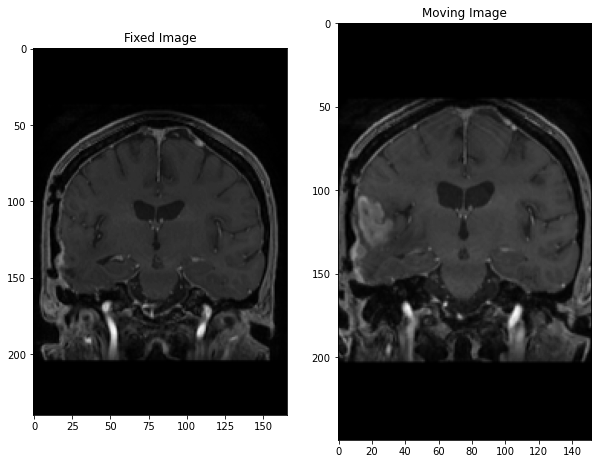

In [5]:
# This function will be used to plot the fixed and moving images
def plot_images(fixed_image_data, moving_image_data):
    plt.figure(figsize=(10, 10))

    # 1 row, 2 columns, this is the information for the first plot
    plt.subplot(1, 2, 1)
    
    # Fixed_image_data.shape[0] // 2 - This is the first argument, it specifes we want the middle row
    # : - The second argument, we specify we want all the columns in that row
    # : - The third argument, we specify we want all the colour channels in that row and column
    plt.imshow(fixed_image_data[fixed_image_data.shape[0] // 2, :, :], cmap='gray')
    plt.title("Fixed Image")
    
    # This is the information for the second plot
    plt.subplot(1, 2, 2)
    plt.imshow(moving_image_data[moving_image_data.shape[0] // 2, :, :], cmap='gray')
    plt.title("Moving Image")

    plt.show()
 
# This function will be used to plot the fixed, moving, and registered images side by side
def plot_results(fixed_image_data, moving_image_data, registered_data):
    plt.figure(figsize=(10, 10))

    # 1 row, 2 columns, this is the information for the first plot
    plt.subplot(1, 3, 1)
    plt.imshow(fixed_image_data[fixed_image_data.shape[0] // 2, :, :], cmap='gray')
    plt.title("Fixed Image")
    
    # This is the information for the second plot
    plt.subplot(1, 3, 2)
    plt.imshow(moving_image_data[moving_image_data.shape[0] // 2, :, :], cmap='gray')
    plt.title("Moving Image")
    
    # This is the information for the third plot
    plt.subplot(1, 3, 3)
    plt.imshow(registered_data[registered_data.shape[0] // 2, :, :], cmap='gray')
    plt.title("Registered Image")

    plt.show()

    
# Calling the fucntion to display the inputted images
plot_images(fixed_image_data, moving_image_data)

## STEP FOUR: Preprocess the input images

It's good practice, and in some cases a necessary step to preprocess the images before registration to enhance the accuracy of the process. Preprocessing helps improve the quality and suitability of the images for registration by addressing a multitude of issues that could affect the registration process. We'll use histogram matching in this tutorial.

Histogram matching is a technique used in image processing to adjust the pixel intensity distribution of an image to match a specified target histogram.

In [6]:
def histogram_match(source_image, target_image):
    matched_image = sitk.HistogramMatching(source_image, target_image, numberOfHistogramLevels=1024, numberOfMatchPoints=7)
    return matched_image

# Here we convert the moving and fixed images to SimpleITK format
fixed_sitk = sitk.GetImageFromArray(fixed_image_data)
moving_sitk = sitk.GetImageFromArray(moving_image_data)

# We perform the histogram matching
matched_moving_sitk = histogram_match(moving_sitk, fixed_sitk)

# We convert the matched image back to numpy array
matched_moving_image_data = sitk.GetArrayFromImage(matched_moving_sitk)


## STEP FIVE: Rigid Registration

Here we will perform rigid registration. Rigid registration is a basic transformation that includes rotation and translation. It preserves angles and distances between points. 

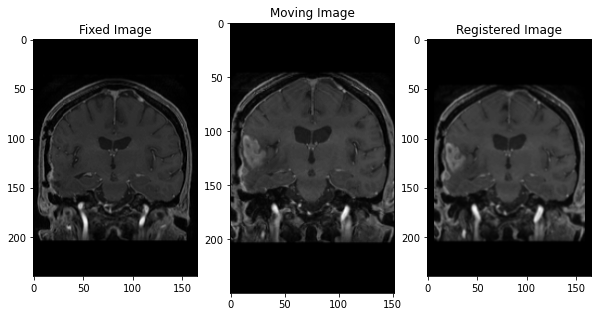

In [7]:
def rigid_registration(fixed_image, moving_image):
    registration_method = sitk.ImageRegistrationMethod()

    # Set the similarity metric
    registration_method.SetMetricAsMeanSquares()

    # Set the optimizer
    registration_method.SetOptimizerAsRegularStepGradientDescent(learningRate=2.0, minStep=1e-4, numberOfIterations=100)

    # Set the initial transformation to identity
    initial_transform = sitk.TranslationTransform(fixed_image.GetDimension())
    registration_method.SetInitialTransform(initial_transform)

    # Perform the registration
    final_transform = registration_method.Execute(fixed_image, moving_image)

    # Transform the moving image
    registered_image = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
    return registered_image, final_transform

# Perform rigid registration
rigid_registered_image, rigid_transform = rigid_registration(fixed_sitk, matched_moving_sitk)

# Convert the registered image to numpy array for visualization
rigid_registered_image_data = sitk.GetArrayFromImage(rigid_registered_image)

plot_results(fixed_image_data, moving_image_data, rigid_registered_image_data)

## STEP SIX: Affine Registration

Moving onto the next type of registration, we will performe affine registraion. Affine registration is a more advanced transformation that includes rotation, translation, scaling, and shearing.

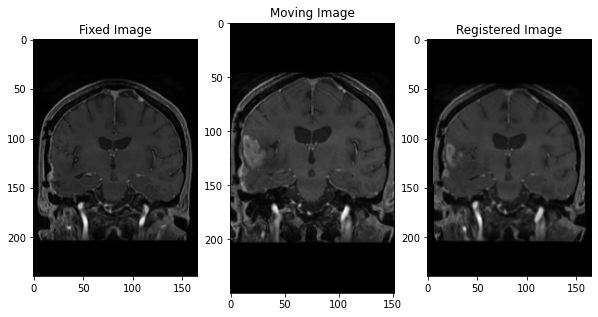

In [8]:
def affine_registration(fixed_image, moving_image):
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-5, numberOfIterations=100, maximumNumberOfCorrections=5)
    initial_transform = sitk.AffineTransform(fixed_image.GetDimension())
    registration_method.SetInitialTransform(initial_transform)
    final_transform = registration_method.Execute(fixed_image, moving_image)
    registered_image = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
    return registered_image, final_transform

# Perform affine registration
affine_registered_image, affine_transform = affine_registration(fixed_sitk, matched_moving_sitk)
affine_registered_image_data = sitk.GetArrayFromImage(affine_registered_image)

plot_results(fixed_image_data, moving_image_data, affine_registered_image_data)


## STEP SEVEN: Non-linear Registration

Finally, the last type of image registration we will be performing non-linear registration. Non-linear registration allows for more complex deformations between the images.

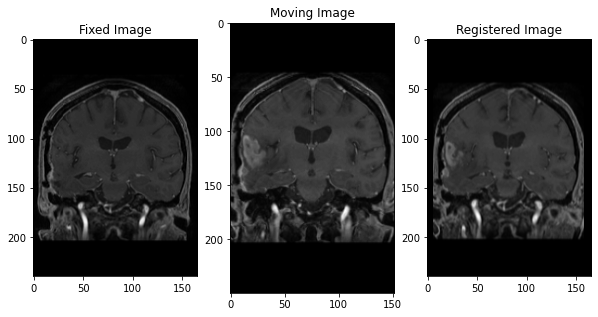

In [9]:
def non_linear_registration(fixed_image, moving_image):
    # Centering the images
    center_transform = sitk.CenteredTransformInitializer(fixed_image, moving_image, sitk.Euler3DTransform())
    moving_image_centered = sitk.Resample(moving_image, fixed_image, center_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

    # Initialize a BSpline transformation
    bspline_transform = sitk.BSplineTransform(fixed_image.GetDimension(), 3)
    registration_method = sitk.ImageRegistrationMethod()

    registration_method.SetMetricAsJointHistogramMutualInformation()
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, estimateLearningRate=registration_method.Once)

    # Set the initial transformation to the BSpline transformation
    registration_method.SetInitialTransform(bspline_transform)
    final_transform = registration_method.Execute(fixed_image, moving_image_centered)
    registered_image = sitk.Resample(moving_image_centered, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image_centered.GetPixelID())
    return registered_image, final_transform

# Perform non-linear registration
non_linear_registered_image, non_linear_transform = non_linear_registration(fixed_sitk, matched_moving_sitk)
non_linear_registered_image_data = sitk.GetArrayFromImage(non_linear_registered_image)

plot_results(fixed_image_data, moving_image_data, non_linear_registered_image_data)



## STEP EIGHT: Visualize Results

Let's visualize the original and registered images. We will also depict the difference between the registered image and the intial fixed image.

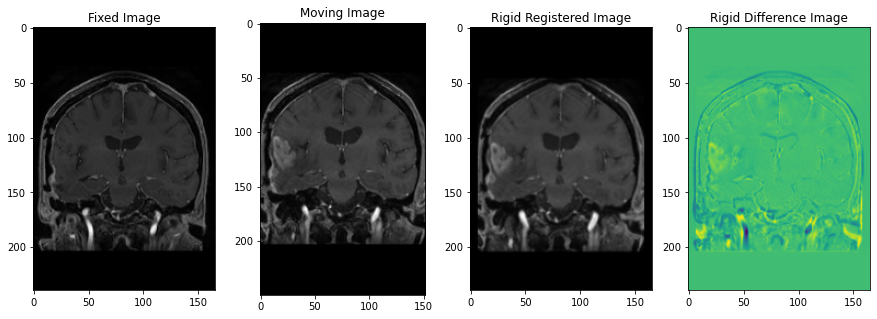

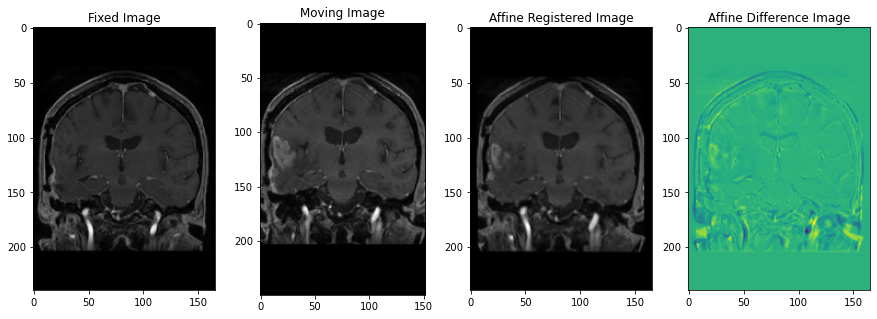

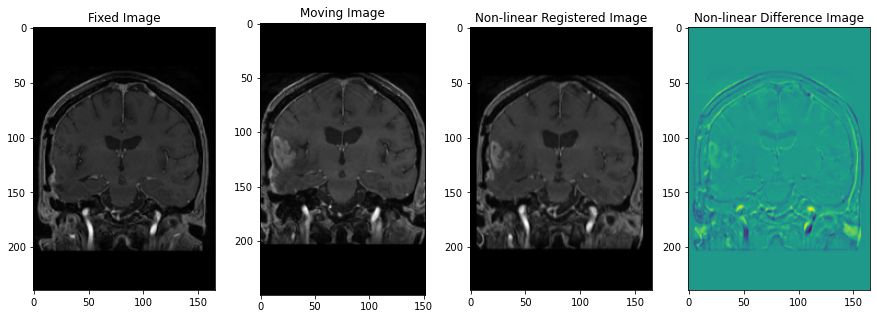

In [10]:
# This function is meant to plot each of the different registered images
def plot_original_and_registered(fixed_image_data, moving_image_data, registered_data, method):
    plt.figure(figsize=(15, 5))

    # Plot Fixed
    plt.subplot(1, 4, 1)
    plt.imshow(fixed_image_data[fixed_image_data.shape[0] // 2, :, :], cmap='gray')
    plt.title("Fixed Image")

    # Plot Moving
    plt.subplot(1, 4, 2)
    plt.imshow(moving_image_data[moving_image_data.shape[0] // 2, :, :], cmap='gray')
    plt.title("Moving Image")

    # Plot the Registered image
    plt.subplot(1, 4, 3)
    plt.imshow(registered_data[registered_data.shape[0] // 2, :, :], cmap='gray')
    plt.title(f"{method} Registered Image")

    # Plot the image that shows the difference between the fixed image and the registered image
    plt.subplot(1, 4, 4)
    # Over here we show the differences
    plt.imshow(registered_data[registered_data.shape[0] // 2, :, :] - fixed_image_data[fixed_image_data.shape[0] // 2, :, :], cmap='viridis')
    plt.title(f"{method} Difference Image")

    plt.show()

# Plot the original and rigid registered images side by side
plot_original_and_registered(fixed_image_data, moving_image_data, rigid_registered_image_data, "Rigid")

# Plot the original and affine registered images side by side
plot_original_and_registered(fixed_image_data, moving_image_data, affine_registered_image_data, "Affine")

# Plot the original and non-linear registered images side by side
plot_original_and_registered(fixed_image_data, moving_image_data, non_linear_registered_image_data, "Non-linear")




## CONCLUSION
In this tutorial, we explored the process of rigid, affine, and non-linear image registration using nibabel to load .nii images and SimpleITK to perform the registration. We applied histogram matching to preprocess the input images, enhancing the accuracy of the registration process. We then performed three different types of image registration:

1) Rigid Registration: Rigid registration allows for translation and rotation between the images while preserving the relative distance between the points. It is best suited for when the images have limited deformations and require only global alignment.

2) Affine Registration: Affine registration extends rigid registration by incorporating scaling and shearing in addition to translation and rotation. This method is most suitable when the images may have some anatomical differences (ie. different field of view).

3) Non-linear Registration: Non-linear registration allows for more complex deformations, providing the ability to register images with more complex anatomical differences or deformations. It is the most flexible and the most powerful method, but because of this, it also requires more computational power.

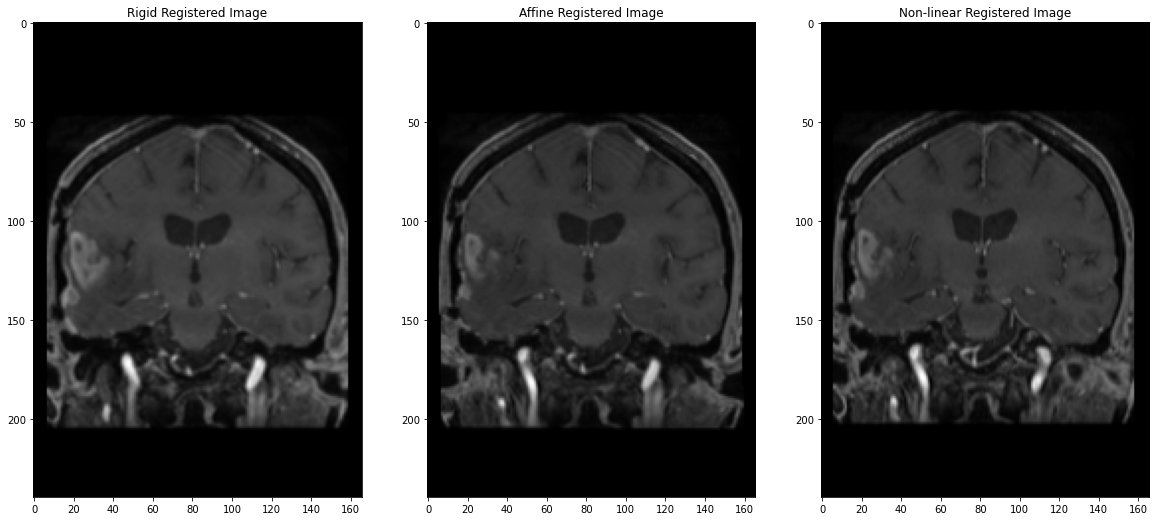

In [12]:
def plot_conclusion(fixed_image_data, moving_image_data, registered_data):
    
    plt.figure(figsize=(20,20))

    plt.subplot(1, 3, 1)
    plt.imshow(fixed_image_data[fixed_image_data.shape[0] // 2, :, :], cmap='gray')
    plt.title("Rigid Registered Image")
    
    
    plt.subplot(1, 3, 2)
    plt.imshow(moving_image_data[moving_image_data.shape[0] // 2, :, :], cmap='gray')
    plt.title("Affine Registered Image")
    
    
    plt.subplot(1, 3, 3)
    plt.imshow(registered_data[registered_data.shape[0] // 2, :, :], cmap='gray')
    plt.title("Non-linear Registered Image")

    plt.show()
    
plot_conclusion(rigid_registered_image_data, affine_registered_image_data, non_linear_registered_image_data)

The quality of the registered images can vary based on the registration method used. Rigid registration generally preserves the global alignment but may struggle with more significant anatomical differences. Affine registration improves on rigid registration and can handle some local differences however, it may not be able to capture complex non-linear deformations. Non-linear registration can handle more flexible deformations, leading to accurate alignment even in the presence of substantial anatomical differences. Non-linear registration usually achieves the highest image quality, but it requires the most computational resources and can be more sensitive to parameter settings.